Tutorial from: https://www.kaggle.com/code/anushkaml/spam-or-ham-sms-email-classifier

Initial Setup

In [79]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [80]:
df = pd.read_csv('spam.csv', encoding = "ISO-8859-1")
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5015,ham,Hey gals...U all wanna meet 4 dinner at nÌÂte?,NaN,NaN,NaN
895,ham,Superb Thought- \Be grateful that u dont have ...,NaN,NaN,NaN
2032,ham,"Yes, i'm small kid.. And boost is the secret o...",NaN,NaN,NaN
738,ham,Wish i were with you now!,NaN,NaN,NaN
1774,ham,"Its ok chikku, and its my 1 of favourite song....",NaN,NaN,NaN


In [81]:
df.shape

(5572, 5)

Data Cleaning:

Dropping non-useful/redundant columns
Label Encoding our data - 0:ham and 1:spam
Null values analysis
Duplicate values analysis etc.

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [83]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True) # drop last 3 cols as they don't make enough sense
df.sample(5)

,v1,v2
4105,ham,K then 2marrow are you coming to class.
1444,ham,Those ducking chinchillas
1958,ham,"Lol ... Oh no babe, I wont be sliding into you..."
5193,ham,"It's wylie, you in tampa or sarasota?"
3262,ham,So u gonna get deus ex?


In [84]:
# renaming the cols
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

,target,text
2670,ham,Yes. They replied my mail. I'm going to the ma...
5499,ham,Now get step 2 outta the way. Congrats again.
1525,ham,Pls pls find out from aunt nike.
4298,ham,Hurt me... Tease me... Make me cry... But in t...
2618,ham,Hey pple...$700 or $900 for 5 nights...Excelle...


In [85]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df['target'] = encoder.fit_transform(df['target'])

df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [86]:
# missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [87]:
# check for duplicate values and delete them
print("delete ", df.duplicated().sum(), "duplicates...")
df = df.drop_duplicates(keep='first')
print("Remaining duplicates: ",df.duplicated().sum())

delete  403 duplicates...
Remaining duplicates:  0


Data Exploration:

In [88]:
df.shape

(5169, 2)

In [89]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [90]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

Data Imbalance Check:

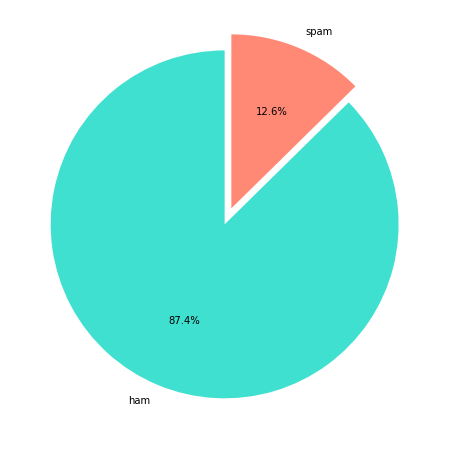

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct='%1.1f%%', colors = ['turquoise','#ff8975'], startangle=90, explode = (0, 0.1))
plt.show()

Data is clearly imbalanced ... TODO: So what now? And why? because it should be 40 / 60 like regarding official numbers from 2020???

Feature Engineering:

In [92]:
import nltk
df['num_characters'] = df['text'].apply(len)

# num of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

# num of sentences
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [93]:
# ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [94]:
import seaborn as sns

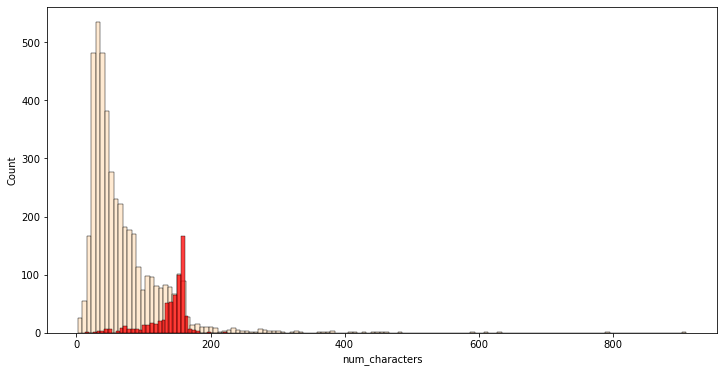

In [95]:
##distribution of spam and ham characters

plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_characters'], color = 'bisque')
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')
plt.show()

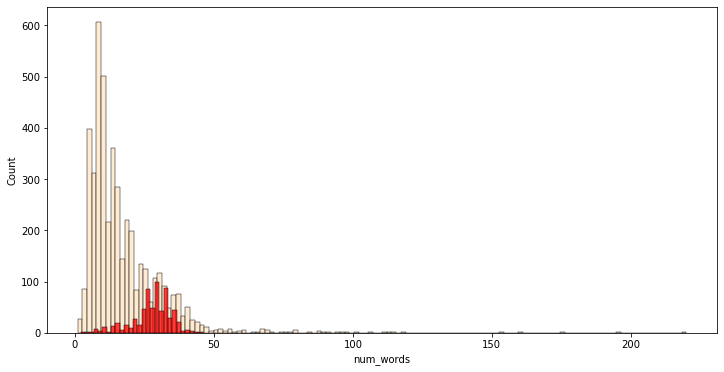

In [96]:
#distribution of spam and ham words

plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'],color='bisque')
sns.histplot(df[df['target'] == 1]['num_words'],color='red')
plt.show()

Outliner Detection:

<Figure size 1008x432 with 0 Axes>

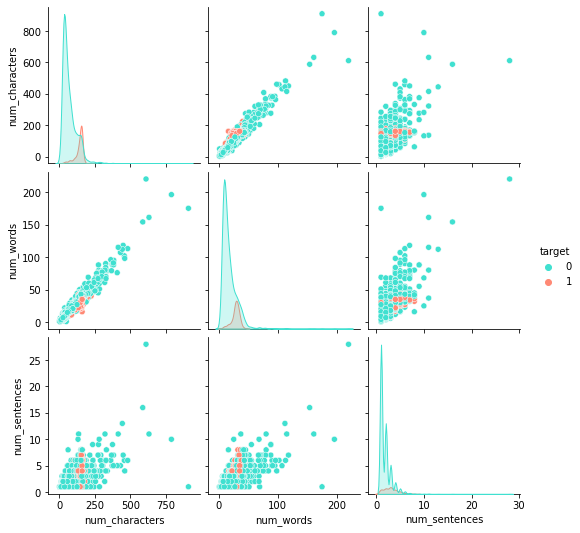

In [97]:
#pairplot
plt.figure(figsize=(14,6))
cols= ['turquoise','#ff8975']
sns.pairplot(df,hue='target',palette=cols)
plt.show()

Observations:
Clear presence of outliers in our data. Also since each of those attributes specify length of a given text, they are likely to be correlated as well.

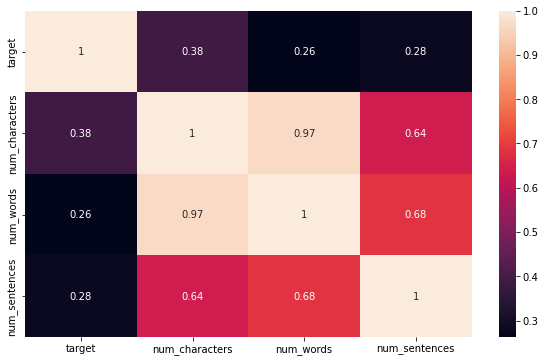

In [98]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True)
plt.show()

Extreme correlation between num_words and num_characters. Same goes for num_words and num_sentences

So we need to consider just one of these three - preferrably num_characters for our model!

Data preprocessing:

In [99]:
#lowercase, tokenization, special chars/punctualtion and stopwords removal

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
import string

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    #retaining only numbers and alphabets
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    #clone copy of list y
    text = y[:]
    y.clear()

    #stopwords removal
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    #stemming
    for i in text:
        y.append(ps.stem(i))


    return " ".join(y)

In [100]:
#Test preprocessing
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [101]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [102]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


View frequent words in our data post text preprocessing

In [103]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

ImportError: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.9/site-packages/wordcloud/query_integral_image.cpython-39-darwin.so, 2): no suitable image found.  Did find:
	/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.9/site-packages/wordcloud/query_integral_image.cpython-39-darwin.so: mach-o, but wrong architecture
	/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.9/site-packages/wordcloud/query_integral_image.cpython-39-darwin.so: mach-o, but wrong architecture

In [ ]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

In [ ]:
plt.figure(figsize=(20,8))
plt.imshow(spam_wc)
plt.show()
